In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.math import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from pandarallel import pandarallel
import os

In [2]:
pandarallel.initialize(progress_bar=True, nb_workers=4)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [45]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# <span style="color:purple"> LEITURA DATASET </span>

In [3]:
columns = [i for i in range(0, 63)]
columns.extend(["classe", "signer"])
dataset = pd.read_csv('dataset_v2.csv')
dataset.columns = columns
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,classe,signer
0,-0.017227,0.074167,0.028766,0.013955,0.058635,0.009331,0.039599,0.031790,0.008871,0.050059,...,-0.002371,-0.023715,-0.027515,0.010693,-0.039081,-0.027290,0.030310,-0.033299,a,1
1,-0.018473,0.077650,0.041800,0.014967,0.061603,0.021215,0.038178,0.035501,0.016030,0.050092,...,-0.003565,-0.024832,-0.028658,0.008516,-0.039817,-0.029420,0.025273,-0.032277,a,1
2,-0.017608,0.076486,0.024926,0.014930,0.061257,0.009007,0.040645,0.035219,0.006765,0.051121,...,-0.005195,-0.026848,-0.029004,0.009567,-0.043633,-0.029709,0.025901,-0.034032,a,1
3,-0.017949,0.074026,0.025973,0.014371,0.061371,0.008799,0.041199,0.034858,0.007288,0.053026,...,-0.006043,-0.025303,-0.028130,0.008016,-0.042826,-0.029535,0.025131,-0.035854,a,1
4,-0.019782,0.073851,0.022678,0.013184,0.060462,0.003672,0.040342,0.034172,0.004060,0.050691,...,-0.006673,-0.024682,-0.028794,0.006464,-0.041332,-0.029523,0.025261,-0.036269,a,1


In [3]:
len(dataset.index)

12580

# <span style="color:purple"> FEATURE ENGINEERING </span>

In [53]:
def dist(row):
    d = []
    for i in range(21):
        for j in range(i+1, 21):
            a = i*3
            b = j*3
            x1, y1, z1 = row[a:a+3]
            x2, y2, z2 = row[b:b+3]
            d.append(np.linalg.norm([x1-x2, y1-y2, z1-z2]))
    return d

In [23]:
new_feats = dataset.parallel_apply(dist, axis=1)

In [24]:
new_feats = np.array([np.array(x) for x in new_feats])
new_feats.shape

(15744, 210)

In [25]:
new_feats = pd.DataFrame(new_feats, columns = [i for i in range(63, 273)])
new_feats.head()

,63,64,65,66,67,68,69,70,71,72,...,263,264,265,266,267,268,269,270,271,272
0,0.036049,0.068586,0.100804,0.125762,0.094236,0.108180,0.092875,0.068497,0.092215,0.107381,...,0.036790,0.045677,0.030445,0.016911,0.028101,0.036699,0.032199,0.025837,0.040866,0.024223
1,0.040339,0.072021,0.105423,0.128574,0.103677,0.117833,0.101243,0.076790,0.100292,0.115127,...,0.039913,0.048455,0.032417,0.018672,0.028711,0.038070,0.034149,0.026512,0.040730,0.022781
2,0.041364,0.072569,0.106332,0.131009,0.105710,0.117446,0.100200,0.075727,0.102700,0.113537,...,0.039762,0.049583,0.035024,0.021047,0.029188,0.038581,0.033654,0.026166,0.039092,0.021624
3,0.042300,0.073763,0.107208,0.131787,0.107135,0.119134,0.102785,0.078731,0.104123,0.115749,...,0.040736,0.051343,0.036532,0.021248,0.029489,0.038360,0.033086,0.025766,0.038390,0.021093
4,0.040867,0.072864,0.105149,0.129026,0.105465,0.115816,0.099173,0.075582,0.102714,0.113762,...,0.039826,0.050607,0.036317,0.020601,0.028745,0.038198,0.032071,0.025811,0.038128,0.021921


In [82]:
dataset = pd.concat([dataset, new_feats], axis=1)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,263,264,265,266,267,268,269,270,271,272
0,-0.015155,0.083723,-0.019764,0.016621,0.067022,-0.016464,0.037898,0.040288,-0.018105,0.048381,...,0.036790,0.045677,0.030445,0.016911,0.028101,0.036699,0.032199,0.025837,0.040866,0.024223
1,-0.017470,0.089129,-0.024697,0.017672,0.070180,-0.018930,0.037136,0.042391,-0.020137,0.047958,...,0.039913,0.048455,0.032417,0.018672,0.028711,0.038070,0.034149,0.026512,0.040730,0.022781
2,-0.018608,0.088464,-0.034686,0.017341,0.069314,-0.027479,0.036115,0.041589,-0.026058,0.046782,...,0.039762,0.049583,0.035024,0.021047,0.029188,0.038581,0.033654,0.026166,0.039092,0.021624
3,-0.018881,0.089806,-0.033932,0.017604,0.069527,-0.027086,0.036691,0.042036,-0.025525,0.047545,...,0.040736,0.051343,0.036532,0.021248,0.029489,0.038360,0.033086,0.025766,0.038390,0.021093
4,-0.018110,0.088998,-0.032207,0.016747,0.068922,-0.024993,0.036877,0.042021,-0.023326,0.047667,...,0.039826,0.050607,0.036317,0.020601,0.028745,0.038198,0.032071,0.025811,0.038128,0.021921


In [4]:
signers_train = [3, 4, 5, 6, 7, 8]
signers_test = [1, 2]

In [44]:
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'y']
classes_bin = ['f', 't']

In [45]:
le = preprocessing.LabelEncoder()
le.fit(classes_bin)

LabelEncoder()

In [78]:
dataset_train = dataset.loc[dataset['signer'].isin(signers_train)]
dataset_train = dataset_train.loc[dataset_train['classe'].isin(classes_bin)]

In [79]:
feats = [i for i in range(0, 63)]

X_train = np.array(dataset_train[feats])
Y_train = np.array(le.transform(dataset_train['classe']))
Y_train = tf.keras.utils.to_categorical(Y_train, len(classes_bin))

X_train = preprocessing.normalize(X_train)

In [64]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [80]:
dataset_test = dataset.loc[dataset['signer'].isin(signers_test)]
dataset_test = dataset_test.loc[dataset_test['classe'].isin(classes_bin)]

In [81]:
X_test = np.array(dataset_test[feats])
Y_test = np.array(le.transform(dataset_test['classe']))
Y_test = tf.keras.utils.to_categorical(Y_test, len(classes_bin))

X_test = preprocessing.normalize(X_test)

# <span style="color:purple"> ANÁLISE DO DATASET</span>

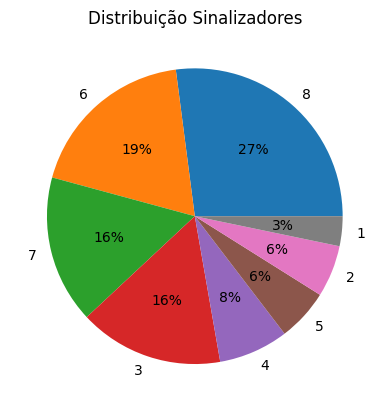

In [53]:
signer_data = dataset['signer'].value_counts()
plt.title('Distribuição Sinalizadores')
_ = plt.pie(signer_data, labels=signer_data.index, autopct='%.0f%%')

f    764
t    628
Name: classe, dtype: int64


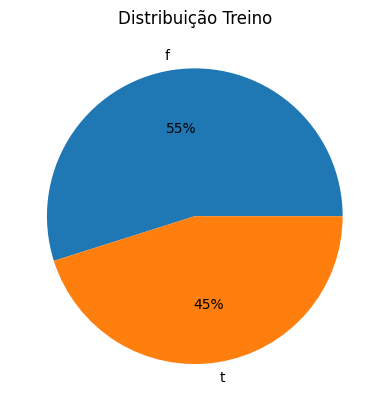

In [54]:
data = dataset_train['classe'].value_counts()
print(data)
plt.title('Distribuição Treino')
_ = plt.pie(data, labels=data.index, autopct='%.0f%%')

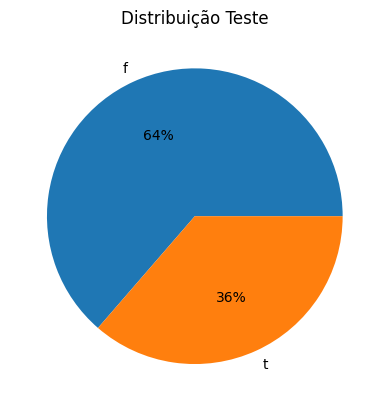

In [55]:
data = dataset_test['classe'].value_counts()
plt.title('Distribuição Teste')
_ = plt.pie(data, labels=data.index, autopct='%.0f%%')

# <span style="color:purple"> MODELO </span>

In [82]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(256, activation='relu', input_shape=(63, 1)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax'),
        
    ]
)

model.compile(loss='mean_squared_error', optimizer="adam", metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 63, 256)           512       
                                                                 
 dense_34 (Dense)            (None, 63, 128)           32896     
                                                                 
 dropout_14 (Dropout)        (None, 63, 128)           0         
                                                                 
 flatten_14 (Flatten)        (None, 8064)              0         
                                                                 
 dense_35 (Dense)            (None, 2)                 16130     
                                                                 
Total params: 49,538
Trainable params: 49,538
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 1s 4ms/step - loss: 0.2334 - accuracy: 0.5783
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1703 - accuracy: 0.8118
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1230 - accuracy: 0.8520
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1008 - accuracy: 0.8793
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0815 - accuracy: 0.9037
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.9239
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0613 - accuracy: 0.9318
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0624 - accuracy: 0.9231
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0492 - accuracy: 0.9533
Epoch 10/100
15/22 [===================>..........] - ETA: 0s - loss: 0.0391 - accuracy: 0.9594

In [76]:
model.evaluate(X_test, Y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.3633 - accuracy: 0.6364


[0.3633010983467102, 0.6363636255264282]

<AxesSubplot:>

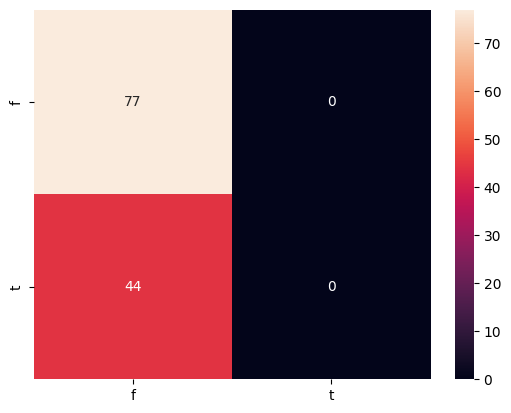

In [77]:
pred = model.predict(X_test)
labels = [np.argmax(y) for y in Y_test] 
predictions = [np.argmax(x) for x in pred]
cm = confusion_matrix(labels, predictions)

df_cm = pd.DataFrame(np.array(cm), index = classes_bin, columns = classes_bin)
sns.heatmap(df_cm, annot=True, fmt=".0f")

# <span style="color:purple"> ANÁLISE DO TREINO </span>

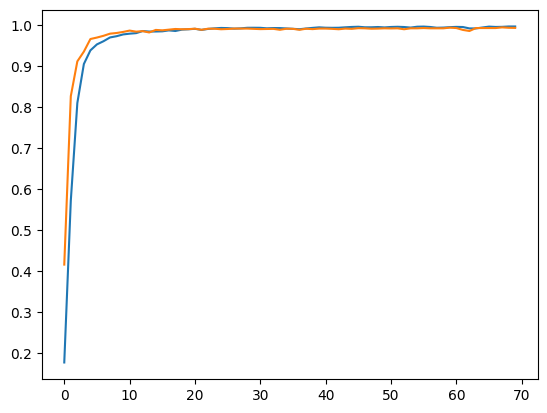

In [219]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc)
plt.plot(val_acc)

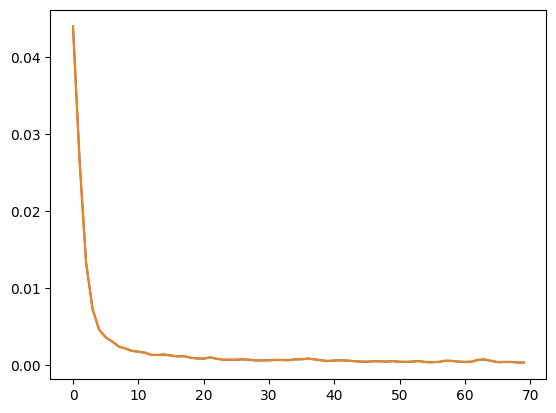

In [220]:
loss = history.history['loss']
val_loss = history.history['loss']

plt.plot(loss)
plt.plot(val_loss)

In [ ]:
def objective(trial):
    classifier = create_classifier(trial)

    optuna_pruning_hook = optuna.integration.TensorFlowPruningHook(
        trial=trial,
        estimator=classifier,
        metric="accuracy",
        run_every_steps=PRUNING_INTERVAL_STEPS,
    )

    train_spec = tf.estimator.TrainSpec(
        input_fn=train_input_fn, max_steps=TRAIN_STEPS, hooks=[optuna_pruning_hook]
    )

    eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, start_delay_secs=0, throttle_secs=0)

    eval_results, _ = tf.estimator.train_and_evaluate(classifier, train_spec, eval_spec)

    return float(eval_results["accuracy"])

# <span style="color:purple"> CONCLUSÃO </span>

* O modelo confunde as letras F e T

* Caso de estudo de *feature engineering* para resolução do problema